# Deep Leraning Base Model

The goal of this notebook is to fit and evaluate a base model with deep learning. We want to see if this deliveres significant different results than the machine learning model based on logistic regression.

## Imports and Data Load

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
from dispatcher.data.join import JoinTables
from dispatcher.transformers.encoders import TimeFeaturesEncoder, DayFeaturesEncoder
from sklearn import set_config; set_config(display='diagram')
from tensorflow.keras import utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
X_train, X_test, y_train, y_test = JoinTables().join_tables()

/Users/martinebel/code/N1tram/dispatcher/dispatcher/data/data.py:77: DtypeWarning: Columns (4,12,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{path}/{table}.csv')


ticket features loaded
order features loaded.
carrier features loaded.


/Users/martinebel/code/N1tram/dispatcher/dispatcher/data/data.py:77: DtypeWarning: Columns (4,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{path}/{table}.csv')


warehouse features loaded
Tables joined.
train test split ready.


In [5]:
X_train.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,PLANNED_PICKUP_TIMESTAMP,CREATED_AT_SHIPMENT
242789,584,495.857977,24,2022-03-22 08:40:22,2022-03-22 08:40:22
507982,616,689.355960,4,2022-03-11 18:13:20,2022-03-11 18:16:24
871815,673,559.701270,53,2022-03-17 20:00:00,2022-03-17 21:31:06
627964,1252,697.699625,56,2022-03-01 15:42:27,2022-03-01 15:42:27
1215136,584,602.957469,15,2022-03-10 14:33:43,2022-03-10 14:33:43


In [6]:
y_train = y_train.astype(int)
y_train.head()

242789     1
507982     2
871815     0
627964     2
1215136    3
Name: DIFF_TRUE, dtype: int64

## Preprocessing


### Target Encoding

We need to encode the target as we work with a multi-classification problem and a deep learning model. 

In [7]:
y_train_cat = utils.to_categorical(y=y_train)
y_test_cat = utils.to_categorical(y=y_test)
y_train_cat.shape

(1063835, 5)

### Hour of Day and Day of Week Encoder

In [8]:
def hour_transform(timestamp):
    hour = timestamp.dt.hour
    norm = 2 * math.pi * hour / 24
    cos = np.cos(norm)
    sin = np.sin(norm)        
    return cos, sin

def day_transform(timestamp):
    day = timestamp.dt.dayofweek
    norm = 2 * math.pi * day / 7
    cos = np.cos(norm)
    sin = np.sin(norm)        
    return cos, sin

In [9]:
X_train['PPU_HOD'] = X_train['PLANNED_PICKUP_TIMESTAMP'].dt.hour
X_train['PPU_DOW'] = X_train['PLANNED_PICKUP_TIMESTAMP'].dt.dayofweek
X_train['CREA_HOD'] = X_train['CREATED_AT_SHIPMENT'].dt.hour
X_train['CREA_DOW'] = X_train['CREATED_AT_SHIPMENT'].dt.dayofweek
#X_train['PPU_HOD_SIN'] = np.sin(2 * math.pi * X_train['PPU_HOD'] / 24)
#X_train['PPU_HOD_COS'] = np.cos(2 * math.pi * X_train['PPU_HOD'] / 24)
#X_train['PPU_DOW_SIN'] = np.sin(2 * math.pi * X_train['PPU_DOW'] / 24)
#X_train['PPU_DOW_COS'] = np.cos(2 * math.pi * X_train['PPU_DOW'] / 24)
#X_train['CREA_HOD_SIN'] = np.sin(2 * math.pi * X_train['CREA_HOD'] / 24)
#X_train['CREA_HOD_COS'] = np.cos(2 * math.pi * X_train['CREA_HOD'] / 24)
#X_train['CREA_DOW_SIN'] = np.sin(2 * math.pi * X_train['CREA_DOW'] / 24)
#X_train['CREA_DOW_COS'] = np.cos(2 * math.pi * X_train['CREA_DOW'] / 24)
X_train.drop(columns=['PLANNED_PICKUP_TIMESTAMP','CREATED_AT_SHIPMENT'], inplace=True)
X_train.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,PPU_HOD,PPU_DOW,CREA_HOD,CREA_DOW
242789,584,495.857977,24,8,1,8,1
507982,616,689.355960,4,18,4,18,4
871815,673,559.701270,53,20,3,21,3
627964,1252,697.699625,56,15,1,15,1
1215136,584,602.957469,15,14,3,14,3


In [10]:
#X_train.drop(columns=['PPU_HOD','PPU_DOW','CREA_HOD','CREA_DOW'], inplace=True)

In [11]:
X_test['PPU_HOD'] = X_test['PLANNED_PICKUP_TIMESTAMP'].dt.hour
X_test['PPU_DOW'] = X_test['PLANNED_PICKUP_TIMESTAMP'].dt.dayofweek
X_test['CREA_HOD'] = X_test['CREATED_AT_SHIPMENT'].dt.hour
X_test['CREA_DOW'] = X_test['CREATED_AT_SHIPMENT'].dt.dayofweek
#X_test['PPU_HOD_SIN'] = np.sin(2 * math.pi * X_test['PPU_HOD'] / 24)
#X_test['PPU_HOD_COS'] = np.cos(2 * math.pi * X_test['PPU_HOD'] / 24)
#X_test['PPU_DOW_SIN'] = np.sin(2 * math.pi * X_test['PPU_DOW'] / 24)
#X_test['PPU_DOW_COS'] = np.cos(2 * math.pi * X_test['PPU_DOW'] / 24)
#X_test['CREA_HOD_SIN'] = np.sin(2 * math.pi * X_test['CREA_HOD'] / 24)
#X_test['CREA_HOD_COS'] = np.cos(2 * math.pi * X_test['CREA_HOD'] / 24)
#X_test['CREA_DOW_SIN'] = np.sin(2 * math.pi * X_test['CREA_DOW'] / 24)
#X_test['CREA_DOW_COS'] = np.cos(2 * math.pi * X_test['CREA_DOW'] / 24)
X_test.drop(columns=['PLANNED_PICKUP_TIMESTAMP','CREATED_AT_SHIPMENT',
                     # 'PPU_HOD','PPU_DOW','CREA_HOD','CREA_DOW'
                    ], inplace=True)
X_test.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,PPU_HOD,PPU_DOW,CREA_HOD,CREA_DOW
1034189,673,360.317753,28,21,1,23,1
349696,310,817.205233,24,15,2,15,2
842289,1260,285.369409,24,4,0,5,0
1463960,604,896.317844,76,12,1,11,1
175827,368,834.120897,16,15,2,17,1


### Scaling Numercial Columns

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[['RELATION_DISTANCE']])

X_train[['RELATION_DISTANCE']] = scaler.transform(X_train[['RELATION_DISTANCE']])
X_test[['RELATION_DISTANCE']] = scaler.transform(X_test[['RELATION_DISTANCE']])

In [13]:
X_train.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,PPU_HOD,PPU_DOW,CREA_HOD,CREA_DOW
242789,584,-0.251708,24,8,1,8,1
507982,616,0.480447,4,18,4,18,4
871815,673,-0.010139,53,20,3,21,3
627964,1252,0.512018,56,15,1,15,1
1215136,584,0.153533,15,14,3,14,3


### Encoding `WAREHOUSE_ID`

In [14]:
encoded_wh = pd.get_dummies(X_train['WAREHOUSE_ID'], prefix='WH')
X_train = pd.concat([X_train, encoded_wh], axis=1)
X_train.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,PPU_HOD,PPU_DOW,CREA_HOD,CREA_DOW,WH_74,WH_96,WH_98,...,WH_1391,WH_1399,WH_1405,WH_1414,WH_1425,WH_1437,WH_1444,WH_1446,WH_1447,WH_1482
242789,584,-0.251708,24,8,1,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507982,616,0.480447,4,18,4,18,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
871815,673,-0.010139,53,20,3,21,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627964,1252,0.512018,56,15,1,15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1215136,584,0.153533,15,14,3,14,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
encoded_ca = pd.get_dummies(X_train['CARRIER_COMPANY_ID'], prefix='CA')
X_train = pd.concat([X_train, encoded_ca], axis=1)
X_train.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,PPU_HOD,PPU_DOW,CREA_HOD,CREA_DOW,WH_74,WH_96,WH_98,...,CA_41,CA_51,CA_53,CA_54,CA_56,CA_62,CA_74,CA_76,CA_83,CA_84
242789,584,-0.251708,24,8,1,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507982,616,0.480447,4,18,4,18,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
871815,673,-0.010139,53,20,3,21,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
627964,1252,0.512018,56,15,1,15,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1215136,584,0.153533,15,14,3,14,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
encoded = pd.get_dummies(X_train['PPU_HOD'], prefix='PPU_HOD')
X_train = pd.concat([X_train, encoded], axis=1)
encoded = pd.get_dummies(X_train['PPU_DOW'], prefix='PPU_DOW')
X_train = pd.concat([X_train, encoded], axis=1)
encoded = pd.get_dummies(X_train['CREA_HOD'], prefix='CREA_HOD')
X_train = pd.concat([X_train, encoded], axis=1)
encoded = pd.get_dummies(X_train['CREA_DOW'], prefix='CREA_DOW')
X_train = pd.concat([X_train, encoded], axis=1)
X_train.drop(columns=['PPU_HOD','PPU_DOW','CREA_HOD','CREA_DOW'], inplace=True)
X_train.head()

,WAREHOUSE_ID,RELATION_DISTANCE,CARRIER_COMPANY_ID,WH_74,WH_96,WH_98,WH_136,WH_171,WH_310,WH_348,...,CREA_HOD_21,CREA_HOD_22,CREA_HOD_23,CREA_DOW_0,CREA_DOW_1,CREA_DOW_2,CREA_DOW_3,CREA_DOW_4,CREA_DOW_5,CREA_DOW_6
242789,584,-0.251708,24,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
507982,616,0.480447,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
871815,673,-0.010139,53,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
627964,1252,0.512018,56,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1215136,584,0.153533,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
X_train.drop(columns=['CARRIER_COMPANY_ID','WAREHOUSE_ID'], inplace=True)

In [18]:
encoded_wh = pd.get_dummies(X_test['WAREHOUSE_ID'], prefix='WH')
X_test = pd.concat([X_test, encoded_wh], axis=1)
encoded_ca = pd.get_dummies(X_test['CARRIER_COMPANY_ID'], prefix='CA')
X_test = pd.concat([X_test, encoded_ca], axis=1)
X_test.drop(columns=['CARRIER_COMPANY_ID','WAREHOUSE_ID'], inplace=True)

In [19]:
X_train_final = X_train.copy()

In [20]:
X_train_final.shape

(1063835, 199)

## Buidling Neural Network

In [21]:
def initialize_model():
    
    #############################
    #  1 - Model architecture   #
    #############################    
    
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_dim=199))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss='categorical_crossentropy', # different from binary_crossentropy because we have multiple classes
                  optimizer='adam', 
                  metrics=['accuracy']) 

    return model 


model = initialize_model()

2022-06-04 10:34:00.777313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                10000     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 16)                416       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 11,776
Trainable params: 11,776
Non-trainable params: 0
_________________________________________________________________


In [23]:
es = EarlyStopping(patience=15)
history = model.fit(X_train_final, y_train_cat,
                    validation_split = 0.3,
                    epochs = 500,
                    batch_size = 32, 
                    verbose = 1, 
                    callbacks = [es])

Epoch 1/500
23272/23272 [==============================] - 44s 2ms/step - loss: 0.4983 - accuracy: 0.7927 - val_loss: 0.4430 - val_accuracy: 0.8150
Epoch 2/500
23272/23272 [==============================] - 44s 2ms/step - loss: 0.4343 - accuracy: 0.8158 - val_loss: 0.4261 - val_accuracy: 0.8180
Epoch 3/500
23272/23272 [==============================] - 46s 2ms/step - loss: 0.4216 - accuracy: 0.8201 - val_loss: 0.4200 - val_accuracy: 0.8204
Epoch 4/500
23272/23272 [==============================] - 45s 2ms/step - loss: 0.4146 - accuracy: 0.8225 - val_loss: 0.4134 - val_accuracy: 0.8263
Epoch 5/500
23272/23272 [==============================] - 49s 2ms/step - loss: 0.4102 - accuracy: 0.8237 - val_loss: 0.4119 - val_accuracy: 0.8253
Epoch 6/500
23272/23272 [==============================] - 44s 2ms/step - loss: 0.4071 - accuracy: 0.8248 - val_loss: 0.4068 - val_accuracy: 0.8261
Epoch 7/500
23272/23272 [==============================] - 42s 2ms/step - loss: 0.4043 - accuracy: 0.8256 - val_

Best score was reached with 5 categories and using `day_of_week` and `hour_of_day` one-hot-encoded in contrast to sin and cos encoded.
Current benchmark: 0.8273

In [32]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.375,0.46))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0.79,0.85))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

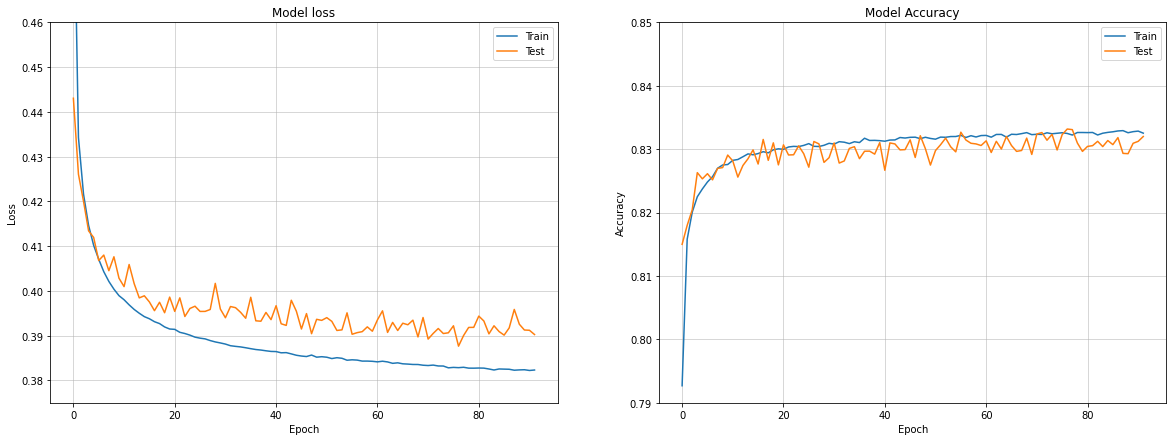

In [33]:
import matplotlib.pyplot as plt
plot_loss_accuracy(history)

In [ ]:
model.evaluate(X=X_test)